In [1]:
import os
import glob
import itertools
import pickle

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Read in daily data
data_path = os.path.join('.', 'data')
daily_data_path = os.path.join(data_path, 'day_approach_maskedID_timeseries.csv')
weekly_data_path = os.path.join(data_path, 'week_approach_maskedID_timeseries.csv')

daily_df = pd.read_csv(daily_data_path)
daily_df.head()

,nr. sessions,total km,km Z3-4,km Z5-T1-T2,km sprinting,strength training,hours alternative,perceived exertion,perceived trainingSuccess,perceived recovery,nr. sessions.1,total km.1,km Z3-4.1,km Z5-T1-T2.1,km sprinting.1,strength training.1,hours alternative.1,perceived exertion.1,perceived trainingSuccess.1,perceived recovery.1,nr. sessions.2,total km.2,km Z3-4.2,km Z5-T1-T2.2,km sprinting.2,strength training.2,hours alternative.2,perceived exertion.2,perceived trainingSuccess.2,perceived recovery.2,nr. sessions.3,total km.3,km Z3-4.3,km Z5-T1-T2.3,km sprinting.3,strength training.3,hours alternative.3,perceived exertion.3,perceived trainingSuccess.3,perceived recovery.3,nr. sessions.4,total km.4,km Z3-4.4,km Z5-T1-T2.4,km sprinting.4,strength training.4,hours alternative.4,perceived exertion.4,perceived trainingSuccess.4,perceived recovery.4,nr. sessions.5,total km.5,km Z3-4.5,km Z5-T1-T2.5,km sprinting.5,strength training.5,hours alternative.5,perceived exertion.5,perceived trainingSuccess.5,perceived recovery.5,nr. sessions.6,total km.6,km Z3-4.6,km Z5-T1-T2.6,km sprinting.6,strength training.6,hours alternative.6,perceived exertion.6,perceived trainingSuccess.6,perceived recovery.6,Athlete ID,injury,Date
0,1.0,5.8,0.0,0.6,1.2,0.0,0.00,0.11,0.00,0.18,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,1.0,0.00,0.10,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,0.0,1.08,0.08,0.00,0.18,1.0,16.4,10.0,0.0,0.0,1.0,0.0,0.11,0.00,0.17,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.10,0.00,0.15,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,1.0,0.00,0.10,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,0.0,1.08,0.08,0.00,0.18,1.0,16.4,10.0,0.0,0.0,1.0,0.00,0.11,0.00,0.17,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.10,0.00,0.15,1.0,5.2,0.0,0.5,1.2,0.0,0.0,0.10,0.00,0.17,0,0,1
2,1.0,0.0,0.0,0.0,0.0,1.0,0.00,0.10,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,0.0,1.08,0.08,0.00,0.18,1.0,16.4,10.0,0.0,0.0,1.0,0.00,0.11,0.00,0.17,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.10,0.00,0.15,1.0,5.2,0.0,0.5,1.2,0.0,0.0,0.10,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.01,-0.01,-0.01,0,0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,0.0,1.08,0.08,0.00,0.18,1.0,16.4,10.0,0.0,0.0,1.0,0.00,0.11,0.00,0.17,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.10,0.00,0.15,1.0,5.2,0.0,0.5,1.2,0.0,0.00,0.10,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.10,0.00,0.17,0,0,3
4,1.0,0.0,0.0,0.0,0.0,0.0,1.08,0.08,0.00,0.18,1.0,16.4,10.0,0.0,0.0,1.0,0.00,0.11,0.00,0.17,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.10,0.00,0.15,1.0,5.2,0.0,0.5,1.2,0.0,0.00,0.10,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.10,0.00,0.17,1.0,17.6,7.2,0.0,0.0,0.0,0.0,0.11,0.00,0.17,0,0,4


In [3]:
# Create datasets
target_col = 'injury'
feat_cols = [c for c in daily_df.columns if c not in ['Athlete ID', 'injury', 'Date']]

X = daily_df[feat_cols].values
y = daily_df[target_col].values

In [4]:
# Create functions for cross validation - ensure train/test splits preserve class imbalance of full dataset
from sklearn.model_selection import cross_validate, StratifiedKFold

def run_cv(model, X, y, scoring, n_splits, verbose=0, return_estimators=False):
    cv_results = cross_validate(model, X, y, scoring=scoring, cv=StratifiedKFold(n_splits=n_splits), verbose=verbose, return_estimator=return_estimators)
    return cv_results

def display_results(results_dict):
    for k in results_dict:
        if isinstance(results_dict[k], type(np.array([]))):
            print(f"Average {k.capitalize()}: {results_dict[k].mean():04f}")
            print()

In [46]:
# Split data into train and test
from sklearn.model_selection import train_test_split

# Get indices of both classes
inj_idxs = np.where(y == 1)[0]
non_inj_idxs = np.where(y == 0)[0]

# Partition training/test sets -> preserve class distribution
test_sz = 0.2
test_idxs = np.concatenate((np.random.choice(inj_idxs, size=int(test_sz*inj_idxs.size), replace=False),
                            np.random.choice(non_inj_idxs, size=int(test_sz*non_inj_idxs.size), replace=False)))
train_idxs = np.array(list(set(range(daily_df.shape[0])) - set(test_idxs)))

X_train, X_test, y_train, y_test = X[train_idxs], X[test_idxs], y[train_idxs], y[test_idxs]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34214, 70), (8552, 70), (34214,), (8552,))

## Linear regression

In [72]:
# Normalize data using min-max scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [73]:
# Fit linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
lin_reg = LinearRegression()
lin_reg.fit(X_train_sc, y_train)

# Evaluate on test set
preds = lin_reg.predict(X_test_sc)

mae = mean_absolute_error(y_test, preds)
print('Linear regression test mean-absolute error: ', mae)

Linear regression test mean-absolute error:  0.027100053534883487


<AxesSubplot:xlabel='coefs', ylabel='Count'>

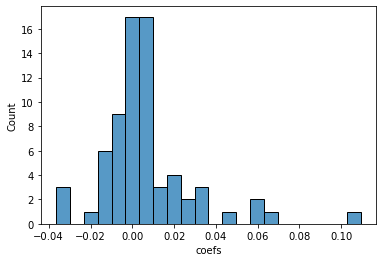

In [75]:
# Plot histogram of coefficients
lin_reg_coefs = pd.DataFrame(lin_reg.coef_, index=feat_cols, columns=['coefs'])
sns.histplot(x='coefs', data=lin_reg_coefs)

## Logistic Regression

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

log_reg = LogisticRegression(solver='liblinear', class_weight='balanced')
log_reg.fit(X_train_sc, y_train)

# Evaluate on test set
pred_probs = log_reg.predict_proba(X_test_sc)
preds = log_reg.predict(X_test_sc)

f1 = f1_score(y_test, preds)
print('Logistic regression test F1-Score: ', f1)

Logistic regression test F1-Score:  0.04424778761061947


<AxesSubplot:xlabel='precision', ylabel='recall'>

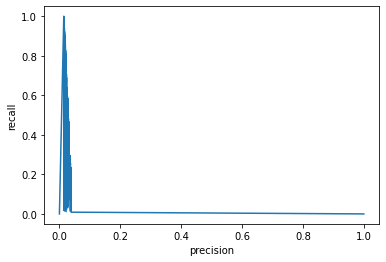

In [148]:
# Examine precision-recall curve
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, pred_probs[:, 1])
pr_df = pd.DataFrame({'precision': precision, 'recall': recall})
sns.lineplot(x='precision', y='recall', data=pr_df)

ROC-AUC score:  0.6336717843069929


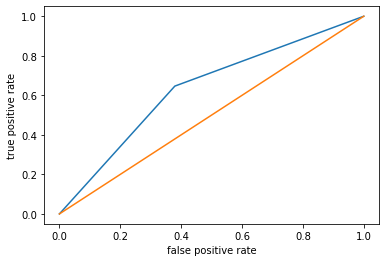

In [157]:
# Examine ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, preds)
roc_auc_score = roc_auc_score(y_test, preds)

fig, ax = plt.subplots()
roc_df = pd.DataFrame({'false positive rate': fpr, 'true positive rate': tpr})
sns.lineplot(x='false positive rate', y='true positive rate', data=roc_df, ax=ax)
plt.plot([0, 1], [0, 1])
print('ROC-AUC score: ', roc_auc_score)

## TODO: try complement naive-bayes

## Feature selection

In [158]:
# TODO: low variance features, correlated features, univariate feature selection, pca -> https://towardsdatascience.com/feature-selection-and-dimensionality-reduction-f488d1a035de